In [2]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

Matplotlib is building the font cache; this may take a moment.


## Chargement du modèle yamnet pré-entrainé

https://www.tensorflow.org/hub/tutorials/yamnet?hl=fr

In [25]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [6]:
import csv
# Find the name of the class with the top score when mean-aggregated across frames.
def class_names_from_csv(class_map_csv_text):
  """Returns list of class names corresponding to score vector."""
  class_names = []
  with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      class_names.append(row['display_name'])

  return class_names

class_map_path = yamnet_model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)


In [9]:
class_names[0:10]

['Speech',
 'Child speech, kid speaking',
 'Conversation',
 'Narration, monologue',
 'Babbling',
 'Speech synthesizer',
 'Shout',
 'Bellow',
 'Whoop',
 'Yell']

In [10]:
def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=16000):
  """Resample waveform if required."""
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) /
                               original_sample_rate * desired_sample_rate))
    waveform = scipy.signal.resample(waveform, desired_length)
  return desired_sample_rate, waveform

In [16]:
from IPython.display import Audio
from scipy.io import wavfile

# wav_file_name = 'speech_whistling2.wav'
wav_file_name = 'miaow_16k.wav'
sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')
sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

# Show some basic information about the audio.
duration = len(wav_data)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(wav_data)}')

# Listening to the wav file.
Audio(wav_data, rate=sample_rate)


Sample rate: 16000 Hz
Total duration: 6.73s
Size of the input: 107698


c:\Users\Florent\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  


In [19]:
waveform = wav_data / tf.int16.max

In [20]:
# Run the model, check the output.
scores, embeddings, spectrogram = yamnet_model(waveform)


In [21]:
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = class_names[scores_np.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: Animal


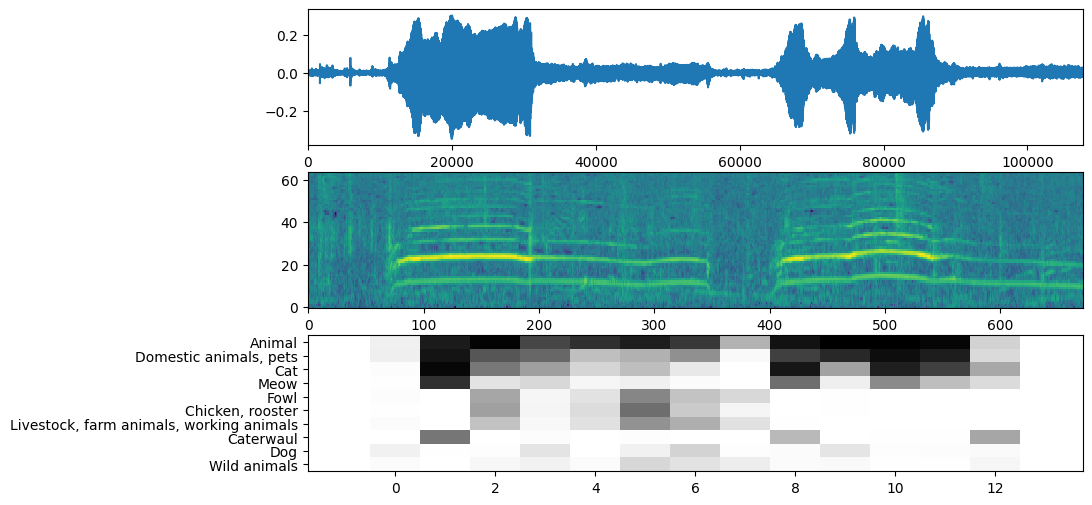

In [24]:
plt.figure(figsize=(10, 6))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))


## Transfer learning

https://www.tensorflow.org/tutorials/audio/transfer_learning_audio?hl=en

In [26]:
# Téléchargement du même fichier miaou
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)


215546/215546 [==============================] - 0s 1us/step
./test_data\miaow_16k.wav


In [27]:
# Chargement et resampling avec le module tensorflow (sans scipy)

# Utility functions for loading audio files and making sure the sample rate is correct.
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [54]:
?tfio.audio.resample

Signature: tfio.audio.resample(input, rate_in, rate_out, name=None)
Docstring:
Resample audio.

Args:
  input: A 1-D (`[samples]`) or 2-D (`[samples, channels]`) or 3-D
    (`[batch, samples, channels]`) `Tensor` of type
    `int16` or `float`. Audio input.
  rate_in: The rate of the audio input.
  rate_out: The rate of the audio output.
  name: A name for the operation (optional).

Returns:
  output: Resampled audio.
File:      c:\users\florent\appdata\local\programs\python\python37\lib\site-packages\tensorflow_io\python\ops\audio_ops.py
Type:      function


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


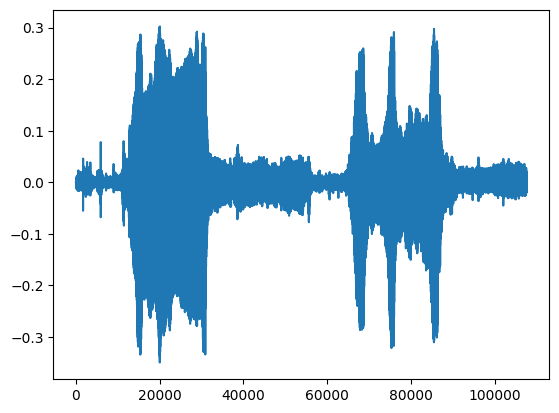

In [28]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)


In [30]:
# Yamnet retourne 521 scores pour chaque frame
# On peut agréger ces scores sur l'ensemble du clip audio afin d'avoir une seule prédiction
len(class_names)

521

In [46]:

scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')

# 13 car il y a 13 frames
print(f'The embeddings shape: {embeddings.shape} (embedding = représentation vecctorielle continue')


The main sound is: Animal
The embeddings shape: (13, 1024) (embedding = représentation vecctorielle continue


In [35]:
# 13 prédictions x 521 scores
scores.shape

TensorShape([13, 521])

In [40]:
# Moyenne des scores pour chacune des 521 classes
class_scores.shape

# ?tf.reduce_mean

TensorShape([521])

In [45]:
# Index du tensorShape qui a le plus haut score
print(top_class)

tf.Tensor(67, shape=(), dtype=int64)


## Application au dataset ESC-50

Qui contient 40 exemples de 5s x 40 classes différentes

In [47]:
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)


   8192/Unknown - 0s 0s/step

In [48]:
esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

# La colonne fold permet de répartir les données entre jeux de train, validation et test
# Il faut les conserver jusqu'à la fin du traitement pour éviter que les différentes frames d'un fichier audio servent à la fois pour le train et le test, ce qui fausserait les résultats


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [49]:
# On sélectionne uniquement deux classes : dog et cat
my_classes = ['dog', 'cat']
map_class_to_id = {'dog':0, 'cat':1}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

# Ajout de la colonne class_id
class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

# Modification de la colonne filename pour avoir un chemin relatif complet
full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)


,filename,fold,target,category,esc10,src_file,take
0,./datasets/ESC-50-master/audio/1-100032-A-0.wav,1,0,dog,True,100032,A
14,./datasets/ESC-50-master/audio/1-110389-A-0.wav,1,0,dog,True,110389,A
157,./datasets/ESC-50-master/audio/1-30226-A-0.wav,1,0,dog,True,30226,A
158,./datasets/ESC-50-master/audio/1-30344-A-0.wav,1,0,dog,True,30344,A
170,./datasets/ESC-50-master/audio/1-32318-A-0.wav,1,0,dog,True,32318,A
175,./datasets/ESC-50-master/audio/1-34094-A-5.wav,1,1,cat,False,34094,A
176,./datasets/ESC-50-master/audio/1-34094-B-5.wav,1,1,cat,False,34094,B
229,./datasets/ESC-50-master/audio/1-47819-A-5.wav,1,1,cat,False,47819,A
230,./datasets/ESC-50-master/audio/1-47819-B-5.wav,1,1,cat,False,47819,B
231,./datasets/ESC-50-master/audio/1-47819-C-5.wav,1,1,cat,False,47819,C


In [50]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

L'extraction des fichiers wav va produire des vecteurs de N frames x 1024 valeurs (transformée de fourier ?)

Chaque ligne de filtered_pd va être transformée en N lignes correspondant à 1 frame chacune.

In [53]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [55]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
# unbatch pour transformer une liste de liste en liste aplatie
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [56]:
cached_ds = main_ds.cache()

# Chaque fold contient 8 fichiers audio
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)


## Entrainement du modèle séquentiel

Avec une couche cachée

In [59]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()


Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [60]:
# Etapes non documentées

my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)


In [61]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)


Epoch 1/20
15/15 [==============================] - 14s 119ms/step - loss: 1.0112 - accuracy: 0.8125 - val_loss: 0.2500 - val_accuracy: 0.9187
Epoch 2/20
15/15 [==============================] - 0s 26ms/step - loss: 0.3592 - accuracy: 0.8792 - val_loss: 0.2056 - val_accuracy: 0.9125
Epoch 3/20
15/15 [==============================] - 0s 22ms/step - loss: 0.1975 - accuracy: 0.8958 - val_loss: 0.2019 - val_accuracy: 0.9062
Epoch 4/20
15/15 [==============================] - 0s 21ms/step - loss: 0.2153 - accuracy: 0.9104 - val_loss: 0.2272 - val_accuracy: 0.8813
Epoch 5/20
15/15 [==============================] - 0s 22ms/step - loss: 0.2073 - accuracy: 0.9104 - val_loss: 0.2516 - val_accuracy: 0.8813
Epoch 6/20
15/15 [==============================] - 0s 22ms/step - loss: 0.2756 - accuracy: 0.9125 - val_loss: 0.2296 - val_accuracy: 0.8687


In [62]:
# Evaluation du modèle sur les données de test

loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)


5/5 [==============================] - 0s 17ms/step - loss: 0.2428 - accuracy: 0.9062
Loss:  0.24280516803264618
Accuracy:  0.90625


### Test du modèle sur un fichier wav ne venant pas du dataset

On passe le fichier dans yamnet pour récupérer les embeddings
Ces embeddings sont donnés au model custom, qui produit une classification

In [63]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')


The main sound is: cat


## Création d'un modèle combinant à la fois yamnet et le classifieeur

In [64]:
# On crée une couche ReduceMean personnalisée
# To make it easier to use the model's result, the final layer will be a reduce_mean operation. When using this model for serving (which you will learn about later in the tutorial),
# you will need the name of the final layer. If you don't define one, TensorFlow will auto-define an incremental one that makes it hard to test, as it will keep changing every time
# you train the model. When using a raw TensorFlow operation, you can't assign a name to it. To address this issue, you'll create a custom layer that applies reduce_mean and call
# it 'classifier'.

class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)


In [65]:
saved_model_path = './dogs_and_cats_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)

serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)

serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)


INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet\assets


INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet\assets


`tf.keras.utils.plot_model(serving_model)`

![](https://www.tensorflow.org/static/tutorials/audio/transfer_learning_audio_files/output_y-0bY5FMme1C_0.png)


In [67]:
# Chargement du modèle custom
reloaded_model = tf.saved_model.load(saved_model_path)


In [68]:
# Test sur le fichier hors dataset
reloaded_results = reloaded_model(testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(reloaded_results)]
print(f'The main sound is: {cat_or_dog}')


The main sound is: cat


In [69]:
# Utilisation en serving setup (?)
serving_results = reloaded_model.signatures['serving_default'](testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(serving_results['classifier'])]
print(f'The main sound is: {cat_or_dog}')



The main sound is: cat


### Comparaison de la classification yamnet et modèle custom sur un fichier au hasard du dataset

./datasets/ESC-50-master/audio/5-9032-A-0.wav


Waveform values: [ 3.2084468e-09 -6.4772658e-09 -3.9162309e-09 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]


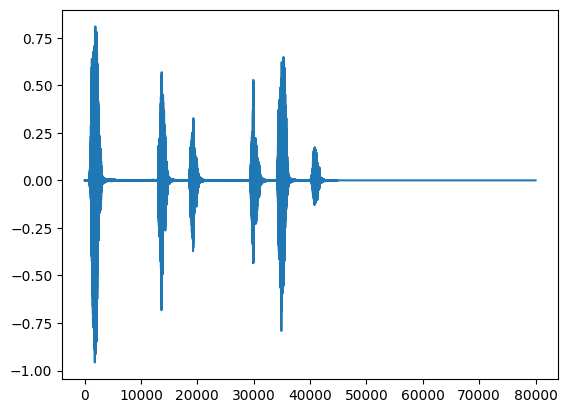

In [70]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 5]
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)


In [71]:
# Run the model, check the output.
scores, embeddings, spectrogram = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]
top_score = class_scores[top_class]
print(f'[YAMNet] The main sound is: {inferred_class} ({top_score})')

reloaded_results = reloaded_model(waveform)
your_top_class = tf.math.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')


[YAMNet] The main sound is: Animal (0.41261354088783264)
[Your model] The main sound is: dog (0.6845158934593201)


In [72]:
reloaded_results

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.2215188 , 0.44691515], dtype=float32)>

In [73]:
your_top_class

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [74]:
?tf.nn.softmax

Signature: tf.nn.softmax(logits, axis=None, name=None)
Docstring:
Computes softmax activations.

Used for multi-class predictions. The sum of all outputs generated by softmax
is 1.

This function performs the equivalent of

```python
softmax = tf.exp(logits) / tf.reduce_sum(tf.exp(logits), axis, keepdims=True)
```
Example usage:

>>> softmax = tf.nn.softmax([-1, 0., 1.])
>>> softmax
<tf.Tensor: shape=(3,), dtype=float32,
numpy=array([0.09003057, 0.24472848, 0.66524094], dtype=float32)>
>>> sum(softmax)
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

Args:
  logits: A non-empty `Tensor`. Must be one of the following types: `half`,
    `float32`, `float64`.
  axis: The dimension softmax would be performed on. The default is -1 which
    indicates the last dimension.
  name: A name for the operation (optional).

Returns:
  A `Tensor`. Has the same type and shape as `logits`.

Raises:
  InvalidArgumentError: if `logits` is empty or `axis` is beyond the last
    dimension of `logits`.
File